In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

(len(train_df), len(test_df))

(891, 418)

In [4]:
# Full dataset is needed for imputing missing values & also for pruning outliers

train_len = len(train_df)
titanic_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


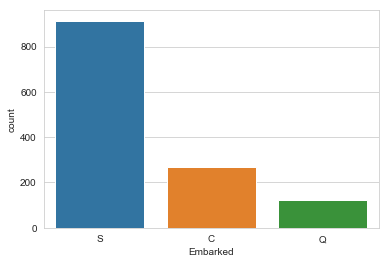

In [5]:
# Impute "Embarked" missing values with the most common value 'S'

sns.countplot(x='Embarked', data=titanic_df)

In [6]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(value='S')

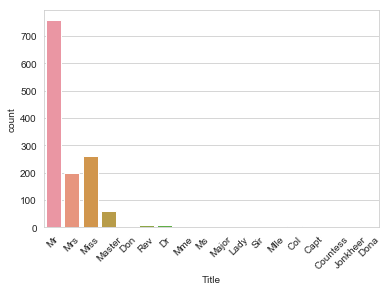

In [7]:
# Extract Title from Name, store in column and plot barplot

import re

titanic_df['Title'] = titanic_df.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

sns.countplot(x='Title', data=titanic_df);
plt.xticks(rotation=45);

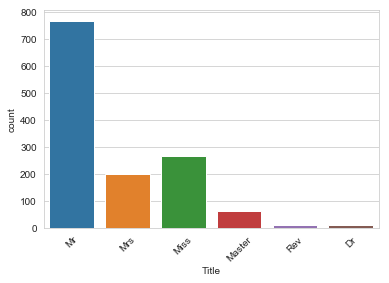

In [8]:
# Replace rare Title with corresponding common Title

titanic_df['Title'] = titanic_df['Title'].replace({'Mlle': 'Miss', 
                                                   'Major': 'Mr', 
                                                   'Col': 'Mr', 
                                                   'Sir': 'Mr', 
                                                   'Don': 'Mr', 
                                                   'Mme': 'Miss', 
                                                   'Jonkheer': 'Mr', 
                                                   'Lady': 'Mrs', 
                                                   'Capt': 'Mr', 
                                                   'Countess': 'Mrs', 
                                                   'Ms': 'Miss', 
                                                   'Dona': 'Mrs'})

sns.countplot(x='Title', data=titanic_df);
plt.xticks(rotation=45);

In [9]:
# Impute "Age" by median of Age of Name's Title group

titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = titanic_df.groupby('Title')['Age'].median()[titles.index(title)]
    titanic_df.loc[(titanic_df['Age'].isnull()) & (titanic_df['Title'] == title), 'Age'] = age_to_impute

Defining new feature Familial

In [10]:
titanic_df['Familial'] = (titanic_df['SibSp'] + titanic_df['Parch']) > 0

Imputing Fare

In [11]:
# Impute "Fare" missing value
# Fare seem to be highly correlated to Pclass & the missing observation's Pclass is 3

medianFare = titanic_df[titanic_df['Pclass'] == 3]['Fare'].median()
titanic_df['Fare'] = titanic_df['Fare'].fillna(value = medianFare)

Categorizing continuous variables Age & Fare

In [12]:
# Categorize continuous variables (Age into 16, i.e., bin width is 80/16)

custom_bucket_array = np.linspace(0, 80, 17)
titanic_df['CatAge'] = pd.cut(titanic_df['Age'], custom_bucket_array)
labels, levels = pd.factorize(titanic_df['CatAge'])
titanic_df['CatAge'] = labels
custom_bucket_array

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,
       65., 70., 75., 80.])

In [13]:
custom_bucket_array = np.linspace(0, 520, 53)
titanic_df['CatFare'] = pd.cut(titanic_df['Fare'], custom_bucket_array)
labels, levels = pd.factorize(titanic_df['CatFare'])
titanic_df['CatFare'] = labels
custom_bucket_array

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
       440., 450., 460., 470., 480., 490., 500., 510., 520.])

Categorizing string variables Sex, Ticket & Embarked

In [15]:
titanic_df['SexBool'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df['EmbarkedInt'] = titanic_df['Embarked'].map({'S': 0, 'C': 1, 'Q':2})
titanic_df['TitleInt'] = titanic_df['Title'].map({'Mr':0, 'Mrs':1, 'Miss':2, 'Master':3, 'Rev':4, 'Dr':5})

Done with Feature Engineering => Now extract train_df & test/test_df

In [16]:
# Get back the features engineered train_df & test_df

train_df = titanic_df.loc[titanic_df['PassengerId'] <= train_len]
test_df = titanic_df.loc[titanic_df['PassengerId'] > train_len].iloc[:, titanic_df.columns != 'Survived']

(len(train_df), len(test_df))

(891, 418)

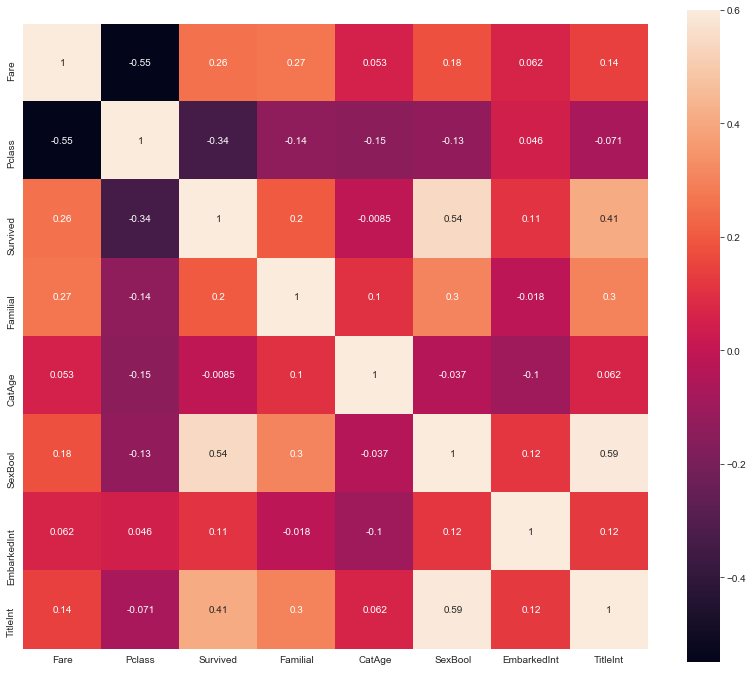

In [17]:
# Heatmap to show Pearson Correlation of bivariate permutations

plt.figure(figsize=(14,12))
foo = sns.heatmap(train_df.drop(['PassengerId', 'Name', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'CatFare', 'Cabin', 'Embarked'],axis=1).corr(), vmax=0.6, square=True, annot=True)

EDA.x: Pclass -vs- Survived

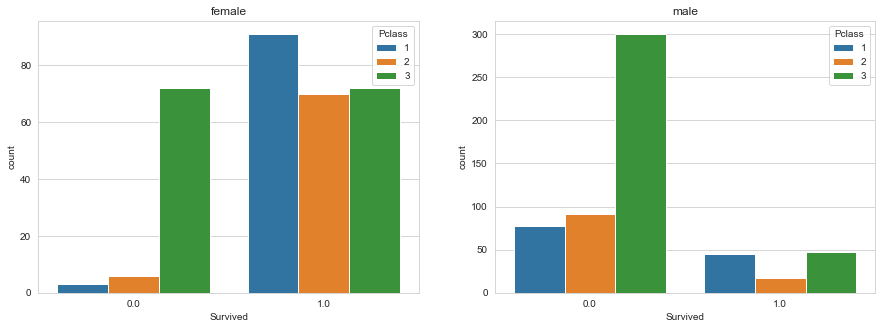

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].set_title('female')
sns.countplot(x='Survived', hue='Pclass', data=titanic_df.loc[titanic_df['Sex'] == 'female'], ax=axs[0])
axs[1].set_title('male')
sns.countplot(x='Survived', hue='Pclass', data=titanic_df.loc[titanic_df['Sex'] == 'male'], ax=axs[1])

EDA.x: Sex -vs- Survived

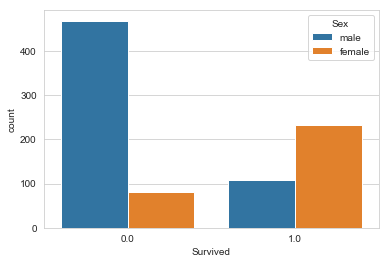

In [19]:
# The Puzzle
sns.countplot(x='Survived', hue='Sex', data=titanic_df)

EDA.x: Checking the survial distribution of male & female across Age bins

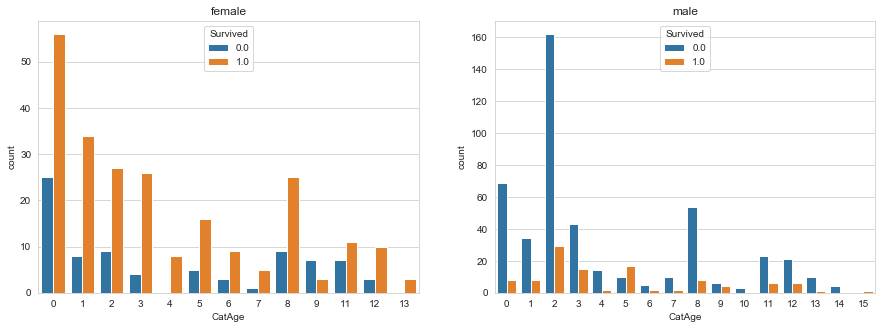

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].set_title('female')
sns.countplot(x='CatAge', hue='Survived', data=train_df.loc[train_df['Sex'] == 'female'], ax=axs[0])
axs[1].set_title('male')
sns.countplot(x='CatAge', hue='Survived', data=train_df.loc[train_df['Sex'] == 'male'], ax=axs[1])

EDA.x: Check the distribution of Survived across Familial

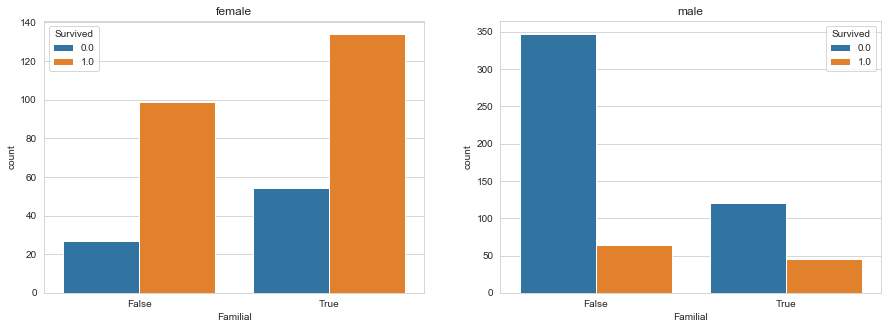

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].set_title('female')
sns.countplot(x='Familial', hue='Survived', data=train_df.loc[train_df['Sex'] == 'female'], ax=axs[0])
axs[1].set_title('male')
sns.countplot(x='Familial', hue='Survived', data=train_df.loc[train_df['Sex'] == 'male'], ax=axs[1])

Features Selection for Model Learning

In [22]:
# Select feature column names and target variable we are going to use for training
# Best score with ['Pclass', 'Fare', 'Sex_binary', 'AgeCategoryIndex', 'Alone']

Columns = ['SexBool', 'Pclass', 'Fare', 'CatAge', 'Familial', 'EmbarkedInt', 'TitleInt']
Label = 'Survived'

train_X = train_df.loc[:, train_df.columns != 'Survived']
train_y = train_df['Survived']

In [23]:
# Instantiate XGB classifier - its hyperparameters are tuned through SkLearn Grid Search below

model = XGBClassifier()

In [24]:
# Performing grid search for important hyperparameters of XGBoost
# It has been observed that non-default value of only n_estimators is useful
# Other hyerparameters default values are the best (learning_Rate as 0.1, max_depth as 3, alpha L1 regularizer as 0 & lambda L2 regularizer as 1)

both_scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss':'neg_log_loss'}
params = {
        'n_estimators': [100, 200, 500, 1000, 1500],
        'learning_rate': [0.05, 0.1, 0.2]
        #'max_depth':[3, 4, 5]
        }

In [25]:
clf = GridSearchCV(model, params, cv=5, scoring=both_scoring, refit='AUC', return_train_score=True)
clf.fit(train_X[Columns], train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500, 1000, 1500], 'learning_rate': [0.05, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss': 'neg_log_loss'},
       verbose=0)

In [26]:
print((clf.best_score_, clf.best_params_))
print("="*30)

print("Grid scores on training data:")
means = clf.cv_results_['mean_test_AUC']
stds = clf.cv_results_['std_test_AUC']
log_losses = clf.cv_results_['std_test_Loss']

for mean, std, log_loss, params in zip(means, stds, log_losses, clf.cv_results_['params']):
    print("AUC Score: %0.3f (+/-%0.03f); Log Loss: %0.3f for %r" % (mean, std * 2, log_loss, params))

(0.8746277044328655, {'learning_rate': 0.2, 'n_estimators': 100})
Grid scores on training data:
AUC Score: 0.870 (+/-0.050); Log Loss: 0.037 for {'learning_rate': 0.05, 'n_estimators': 100}
AUC Score: 0.870 (+/-0.057); Log Loss: 0.047 for {'learning_rate': 0.05, 'n_estimators': 200}
AUC Score: 0.874 (+/-0.056); Log Loss: 0.057 for {'learning_rate': 0.05, 'n_estimators': 500}
AUC Score: 0.873 (+/-0.059); Log Loss: 0.069 for {'learning_rate': 0.05, 'n_estimators': 1000}
AUC Score: 0.872 (+/-0.062); Log Loss: 0.079 for {'learning_rate': 0.05, 'n_estimators': 1500}
AUC Score: 0.871 (+/-0.062); Log Loss: 0.050 for {'learning_rate': 0.1, 'n_estimators': 100}
AUC Score: 0.872 (+/-0.060); Log Loss: 0.057 for {'learning_rate': 0.1, 'n_estimators': 200}
AUC Score: 0.871 (+/-0.062); Log Loss: 0.070 for {'learning_rate': 0.1, 'n_estimators': 500}
AUC Score: 0.868 (+/-0.062); Log Loss: 0.087 for {'learning_rate': 0.1, 'n_estimators': 1000}
AUC Score: 0.864 (+/-0.056); Log Loss: 0.091 for {'learning

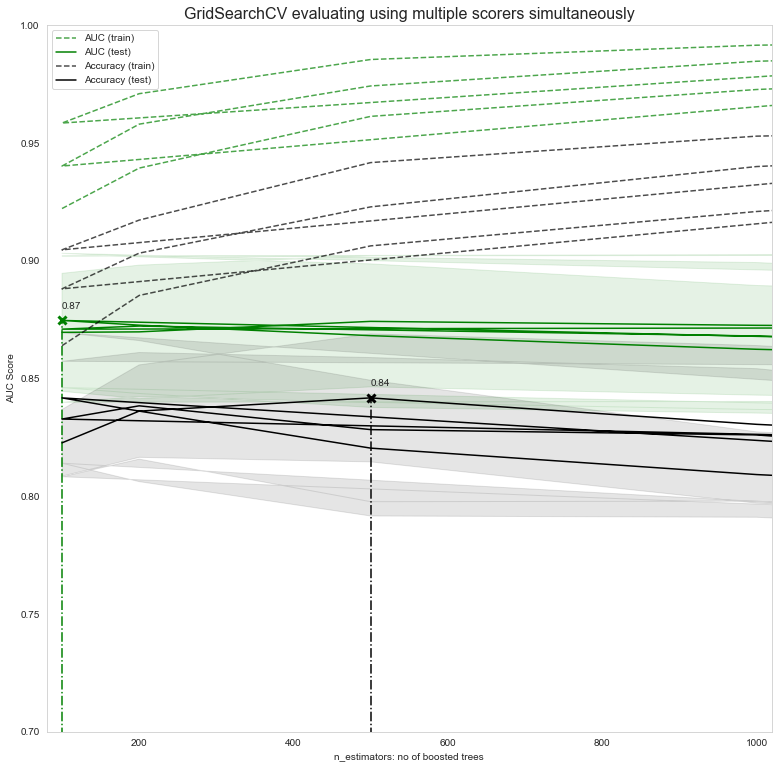

In [27]:
# If grid params permutes across multiple hyperparameters, then below plot would have many lines (n1*n2*n3..) & may look cluttered
# Observe the best AUC & Accuracy

results = clf.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_estimators: no of boosted trees")
plt.ylabel("AUC Score")

ax = plt.gca()
ax.set_xlim(80, 1020)
ax.set_ylim(0.7, 1)

X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(both_scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()